<a href="https://colab.research.google.com/github/jackswanberg/CSCI5541/blob/main/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Huggingface Text Classification Tutorial
This notebook tutorial is taken from the Huggingface website(https://huggingface.co/docs/transformers/tasks/sequence_classification) and modified for CSCI5541.Today we will be:
1.Learning about the concepts of pre-training and fine-tuning
2.Finetuning [DistilBERT](https://huggingface.co/distilbert-base-uncased) on the [winogrande](https://huggingface.co/datasets/winogrande) dataset to determine whether a movie review is positive or negative.
3.Using your finetuned model for inference.
4.Exploring different model/dataset cards in Huggingface to see what other resources exist

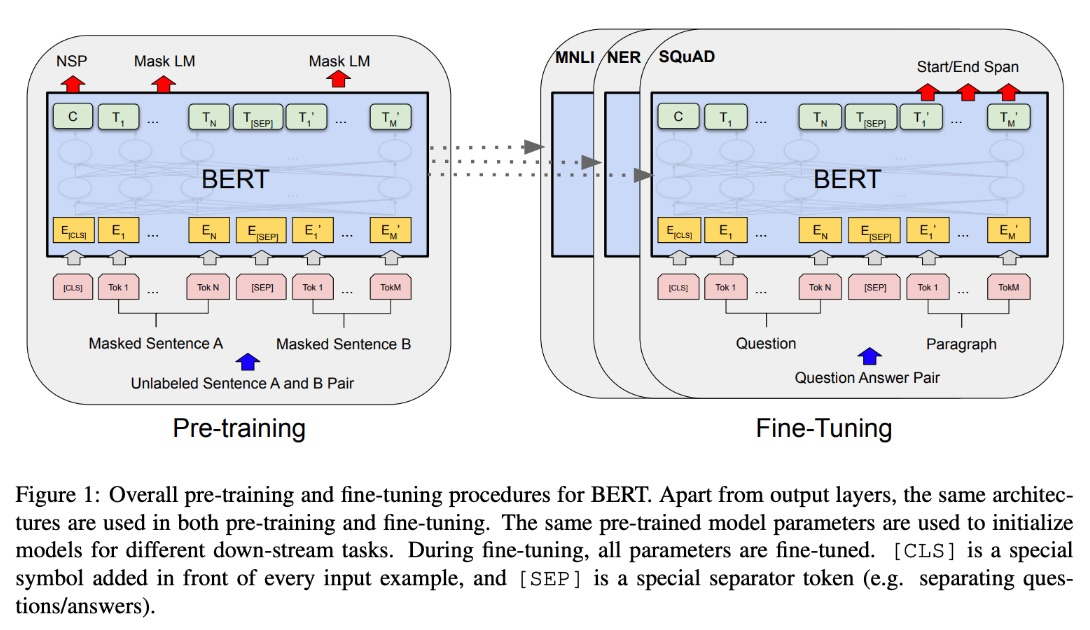

## Pre-Training and Fine-Tuning
Pre-training:
- Pre-training is the process of training a neural network on a large dataset **before** fine-tuning it for a specific task, i.e.training "from scratch."
- Pre-training allows the network to learn general linguistic features and representations that can be useful for many different tasks

Fine-Tuning:
- Fine-tuning is the process of training a pre-trained model on a new(and almost always smaller) dataset/task
- Improves task-specific performance because the model learns to specialize
- Saves time and computing resources since the model doesn't need to learn everything from scratch

<a href="https://aclanthology.org/N19-1423.pdf">Image source</a>

## Let's start fine-tuning!
### 1.Load dataset

In [ ]:
%%capture
# Use this only after you check everything is being loaded properly

# First install necessary libraries
# Exclamation marks for shell commands
! pip install transformers datasets evaluate scikit-learn
! pip install accelerate -U
! pip install wandb

In [ ]:
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import torch

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

device: cuda:0


We will be using the winogrande(Internet Movie Database) dataset from the 🤗 Datasets library:

In [ ]:
from datasets import load_dataset

train_ds = load_dataset('yaful/DeepfakeTextDetect',split='train').shard(num_shards=30,index=0)
val_ds = load_dataset('yaful/DeepfakeTextDetect',split='validation').shard(num_shards=30,index=0)
test_ds = load_dataset('yaful/DeepfakeTextDetect',split='test').shard(num_shards=30,index=0)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/319071 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/56792 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/56819 [00:00<?, ? examples/s]

Generating test_ood_gpt split:   0%|          | 0/1562 [00:00<?, ? examples/s]

Generating test_ood_gpt_para split:   0%|          | 0/2362 [00:00<?, ? examples/s]

The dataset is separated into three sections: "train," "test," and "unsupervised." You'll use the data in the "train" section for training, and you'll use the data in the "test" section to evaluate your model.(The "unsupervised" data is unlabeled, so we will not be using it.)

There are two fields in this dataset:

- `text`: the movie review text.
- `label`: a value that is either `0` for a negative review or `1` for a positive review.

Then take a look at an example:

In [ ]:
train_ds[1]

{'text': "Rappers are not talented. They do what anyone can do. Anyone is capable over saying words over a beat. Some rappers don't even try to make sense, or be clever. I can't believe rappers are allowed to win grammies and different music awards. Poets should be allowed to win grammies too then. Rap to me is like in the same category as a terrible singer sometimes. Every person on this earth that can speak is capable of rapping. You can't say the same for singers, that can sing on key. You might say, it takes skill to rap well. No it doesn't. It takes time, and a pen and paper. It can be mastered relatively easy. Please show me why they deserve to be respected as musicians. Edit 1: Okay uscottevil110 pointed out to me, performing, or the entertainment value is a big part of a rappers act. It takes tremendous confidence and talent to get on stage and move a crowd with your lyrics. Some rappers are capable of this so, I changed my view that some have talent in that regard, but as far 

### 2.Preprocess

The next step is to load a tokenizer to preprocess the `text` field.
A tokenizer converts text to a sequence of tokens, creating a numerical representation of the text.
Notice how there are multiple ways to tokenize text.Make sure to use the right tokenizer for your model.

In [ ]:
from transformers import AutoTokenizer

distilbert_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
bert_cased_tokenizer = AutoTokenizer.from_pretrained('bert-base-cased',use_fast=True)
roberta_tokenizer = AutoTokenizer.from_pretrained('roberta-base')

text = 'Hello everyone! ! antidisestablishmentarianism'

for tokenizer in [distilbert_tokenizer, bert_cased_tokenizer, roberta_tokenizer]:
  print(f'\n\n{tokenizer.name_or_path}')
  vocab = {v: k for k, v in tokenizer.vocab.items()}
  tokenized_text = tokenizer(text)
  print([vocab[id] for id in tokenized_text['input_ids']])

tokenizer = bert_cased_tokenizer

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]



distilbert-base-uncased
['[CLS]', 'hello', 'everyone', '!', '!', 'anti', '##dis', '##est', '##ab', '##lish', '##ment', '##arian', '##ism', '[SEP]']


bert-base-cased
['[CLS]', 'Hello', 'everyone', '!', '!', 'anti', '##dis', '##esta', '##b', '##lish', '##ment', '##arian', '##ism', '[SEP]']


roberta-base
['<s>', 'Hello', 'Ġeveryone', '!', 'Ġ!', 'Ġant', 'idis', 'establishment', 'arian', 'ism', '</s>']


Create a preprocessing function to tokenize `text`.You can specify how to deal with varying input lengths here using the max_length, truncation, and/or padding arguments.(Default is to not truncate or pad.Max length is determined by model.)

https://huggingface.co/docs/transformers/pad_truncation

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples['text'],truncation=True)

To apply the preprocessing function over the entire dataset, use 🤗 Datasets [map](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.map) function.You can speed up `map` by setting `batched=True` to process multiple elements of the dataset at once.

Now create a batch of examples using [DataCollatorWithPadding](https://huggingface.co/docs/transformers/main/en/main_classes/data_collator#transformers.DataCollatorWithPadding).It's more efficient to *dynamically pad* the sentences to the longest length in a batch during collation, instead of padding the whole dataset to the maximium length in the tokenzation process.

In [ ]:
tokenized_train = train_ds.map(preprocess_function, batched=True)
tokenized_val = val_ds.map(preprocess_function, batched=True)
tokenized_test = test_ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/10636 [00:00<?, ? examples/s]

Map:   0%|          | 0/1894 [00:00<?, ? examples/s]

Map:   0%|          | 0/1894 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### 3.Create evaluation method

In [ ]:
len(tokenized_test)

1894

Including a metric during training is often helpful for evaluating your model's performance(otherwise, it just prints the loss).You can quickly load a evaluation method with the 🤗 [Evaluate](https://huggingface.co/docs/evaluate/index) library.For this task, load the [accuracy](https://huggingface.co/spaces/evaluate-metric/accuracy) metric(see the 🤗 Evaluate [quick tour](https://huggingface.co/docs/evaluate/a_quick_tour) to learn more about how to load and compute a metric):

In [ ]:
import evaluate

# Proportion of correct predictions among the total number of cases processed
accuracy = evaluate.load('accuracy')

Then create a function that passes your predictions and labels to [compute](https://huggingface.co/docs/evaluate/main/en/package_reference/main_classes#evaluate.EvaluationModule.compute) to calculate the accuracy:

In [ ]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

Your `compute_metrics` function is ready to go now -- you'll need it later when you set up your training.

### 4.Train

Before you start training your model, create a map of the expected ids to their labels with `id2label` and `label2id`.

In [ ]:
labels = ['Machine Generated', 'Human']
id2label = {i: label for i, label in enumerate(labels)}
label2id = {label: i for i, label in id2label.items()}

print('id2label:', id2label)
print('label2id:', label2id)

id2label: {0: 'Machine Generated', 1: 'Human'}
label2id: {'Machine Generated': 0, 'Human': 1}


Next, we will be using the Trainer class, which is wrapper code that abstracts away the details of training and evaluation.It is optimized for training 🤗 Transformers and makes it easier for us to train models without writing much code.

[More info on Trainers](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer)<br/>
[Trainer Tutorial](https://huggingface.co/docs/transformers/main/en/tasks/../training#train-with-pytorch-trainer)

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# This automodel class gives us the model with pretrained weights + a sequence classification head
# We specify how many labels we need so that the model has the correct number of outputs
# We specify id2label/label2id so that the model understands the label associated with each output
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-cased", num_labels=len(labels), id2label=id2label, label2id=label2id
)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


At this point, only three steps remain:

1.Define your training hyperparameters in [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments).The only required parameter is `output_dir` which specifies where to save your model.At the end of each epoch, the [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) will evaluate the accuracy and save the training checkpoint.
2.Pass the training arguments to [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) along with the model, dataset, tokenizer, data collator, and `compute_metrics` function.
3.Call [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train) to finetune your model(may take some time).

In [ ]:
# https://huggingface.co/transformers/v4.4.2/main_classes/trainer.html#trainingarguments
lr=2e-5
epochs=5

training_args = TrainingArguments(
    output_dir='my_awesome_model',
    learning_rate=lr,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=epochs,
    weight_decay=0.01,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
)

wandb.init(
    # Set the project where this run will be logged
    project="my-awesome-project",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
    },
)


wandb: Currently logged in as: swanb045 (swanberg). Use `wandb login --relogin` to force relogin


In [ ]:
import time
import math
from tqdm import tqdm

class CustomTrainer(Trainer):
  def _inner_training_loop(
    self , batch_size =None , args =None , resume_from_checkpoint =None , trial =None ,
    ignore_keys_for_eval = None
 ):
    number_of_epochs = args.num_train_epochs
    start = time.time()
    train_loss =[]
    train_acc =[]
    eval_acc =[]
    criterion = torch.nn.CrossEntropyLoss().to(device)
    self.optimizer = torch.optim.Adam(model.parameters() , lr= args.learning_rate)
    self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer , 1 , gamma =0.9)
    train_dataloader = self.get_train_dataloader()
    eval_dataloader = self.get_eval_dataloader()
    max_steps = math.ceil(args.num_train_epochs * len(train_dataloader))
    for epoch in range(number_of_epochs):
      train_loss_per_epoch = 0
      train_acc_per_epoch = 0

      with tqdm(train_dataloader , unit ="batch") as training_epoch :
        training_epoch.set_description(f" Training Epoch { epoch }")
        for step , inputs in enumerate(training_epoch):
          inputs = inputs.to(device)

          # print(inputs)
          labels = inputs['labels']
          # inputs = inputs[0:-1]
          # print(inputs)
          # forward pass
          self.optimizer.zero_grad()
          output = model(**inputs)
          # print(output['logits'])
          # get the loss
          loss = criterion(output['logits'],labels)# TODO
          train_loss_per_epoch += loss.item()
          # calculate gradients
          loss.backward()
          # update weights
          self.optimizer.step()
          train_acc_per_epoch +=(output['logits'].argmax(1) == labels).sum().item()
      # adjust the learning rate
      self.scheduler.step()
      train_loss_per_epoch /= len(train_dataloader)
      train_acc_per_epoch /=(len(train_dataloader)* batch_size)
      eval_loss_per_epoch = 0
      eval_acc_per_epoch = 0
      with tqdm(eval_dataloader , unit =" batch ") as eval_epoch :
        eval_epoch.set_description(f" Evaluation Epoch{ epoch }")
        for step , inputs in enumerate(eval_epoch):
          inputs = inputs.to(device)
          labels = inputs['labels']
          self.optimizer.zero_grad()
          output = model(**inputs)
          loss = criterion(output['logits'],labels)# TODO
          eval_loss_per_epoch += loss.item()
          eval_acc_per_epoch +=(output['logits'].argmax(1) == labels).sum().item()
      eval_loss_per_epoch /=(len(eval_dataloader))
      eval_acc_per_epoch /=(len(eval_dataloader)* batch_size)
      print(f'\ tTrain Loss : { train_loss_per_epoch :.3f} | Train Acc : {train_acc_per_epoch * 100 :.2f}% ')
      print(f'\ tEval Loss : { eval_loss_per_epoch :.3f} | Eval Acc : {eval_acc_per_epoch * 100 :.2f}%')
      wandb.log({"Train Accuracy": train_acc_per_epoch * 100, "train loss": train_loss_per_epoch,
                 "Eval Accuracy":eval_acc_per_epoch*100,"eval loss":eval_loss_per_epoch})
    print(f'Time : {( time.time() -start)/60 :.3f} minutes')

In [ ]:
# https://huggingface.co/transformers/v4.4.2/main_classes/trainer.html#id1
customtrainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

customtrainer.train()  # do not do this in HW1 :) you will

 Evaluation Epoch0: 100%|██████████| 237/237 [00:44<00:00,  5.37 batch /s]


\ tTrain Loss : 0.384 | Train Acc : 82.72% 
\ tEval Loss : 0.385 | Eval Acc : 81.17%


 Evaluation Epoch1: 100%|██████████| 237/237 [00:44<00:00,  5.37 batch /s]


\ tTrain Loss : 0.138 | Train Acc : 94.68% 
\ tEval Loss : 0.456 | Eval Acc : 81.01%


 Evaluation Epoch2: 100%|██████████| 237/237 [00:44<00:00,  5.38 batch /s]


\ tTrain Loss : 0.029 | Train Acc : 98.95% 
\ tEval Loss : 0.635 | Eval Acc : 84.12%


 Evaluation Epoch3: 100%|██████████| 237/237 [00:44<00:00,  5.38 batch /s]


\ tTrain Loss : 0.018 | Train Acc : 99.36% 
\ tEval Loss : 0.927 | Eval Acc : 78.43%


 Evaluation Epoch4: 100%|██████████| 237/237 [00:43<00:00,  5.39 batch /s]

\ tTrain Loss : 0.009 | Train Acc : 99.65% 
\ tEval Loss : 0.740 | Eval Acc : 82.49%
Time : 73.494 minutes


In [ ]:
torch.cuda.empty_cache()

In [ ]:
from torch.utils.data import DataLoader
test_dataloader = DataLoader(tokenized_test, batch_size=2, shuffle=True)

In [ ]:
customtrainer.predict(tokenized_test)
# with tqdm(test_dataloader) as test_epoch :
#   test_epoch.set_description(f" Test Dataset")
#   for step , inputs in enumerate(test_epoch):
#     print(inputs)
#     # inputs = inputs.to(device)
#     label = inputs['label']
#     output = model(**inputs)
#     loss = criterion(output['logits'],label)
#     test_loss_per_epoch += loss.item()
#     test_acc_per_epoch +=(output['logits'].argmax(1) == label).sum().item()
#   test_loss_per_epoch /=(len(test_dataloader))
#   test_acc_per_epoch /=(len(test_dataloader)* batch_size)

# print(f'\ tTest Loss : { test_loss_per_epoch :.3f} | Test Acc : {test_acc_per_epoch * 100 :.2f}%')

PredictionOutput(predictions=array([[-3.1109529,  3.788704 ],
       [-4.8296328,  5.4466586],
       [-4.1830764,  5.0073385],
       ...,
       [ 2.1386862, -2.7485955],
       [-1.8291042,  2.3898602],
       [-1.2005517,  1.7017417]], dtype=float32), label_ids=array([1, 1, 1, ..., 1, 1, 1]), metrics={'test_loss': 0.7150614261627197, 'test_accuracy': 0.8342133051742344, 'test_runtime': 43.826, 'test_samples_per_second': 43.216, 'test_steps_per_second': 5.408})

In [ ]:
customtrainer.predict(tokenized_test)

<Tip>

[Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) applies dynamic padding by default when you pass `tokenizer` to it.In this case, you actually don't need to specify a data collator explicitly because we're not using any special data collation logic.


<Tip>

For a more in-depth example of how to finetune a model for text classification, take a look at the corresponding
[PyTorch notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/text_classification.ipynb)
or [TensorFlow notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/text_classification-tf.ipynb).

</Tip>

## Inference

Great, now that you've finetuned a model, you can use it for inference!

Grab some text you'd like to run inference on:

In [ ]:
text = "This was a masterpiece.Not completely faithful to the books, but enthralling from beginning to end.Might be my favorite of the three."

The simplest way to try out your finetuned model for inference is to use it in a [pipeline()](https://huggingface.co/docs/transformers/main/en/main_classes/pipelines#transformers.pipeline).Instantiate a `pipeline` for sentiment analysis with your model, and pass your text to it:

In [ ]:
from transformers import pipeline

classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, device=device)
classifier(text)

You can also manually replicate the results of the `pipeline` if you'd like:

Tokenize the text and return PyTorch tensors:

In [ ]:
inputs = tokenizer(text, return_tensors='pt').to(device)  # 'pt' means your tokenizer will return a pytorch tensor

Pass your inputs to the model and return the `logits`:

In [ ]:
from transformers import AutoModelForSequenceClassification

with torch.no_grad():
    logits = model(**inputs).logits

Get the class with the highest probability, and use the model's `id2label` mapping to convert it to a text label:

In [ ]:
predicted_class_id = logits.argmax().item() # is the first output or second output bigger? get ID of bigger output
model.config.id2label[predicted_class_id] # translate ID to human-readable label

## Model/Dateset Cards in Huggingface(Documentation)

Markdown files with information on how to use the model/dataset and other relevant data(metadata, potential limitations, etc.)

Looking for models/datasets to use:<br/>
https://huggingface.co/models<br/>
https://huggingface.co/datasets

More information:<br/>
https://huggingface.co/docs/hub/model-cards<br/>
https://huggingface.co/docs/hub/datasets-cards

Templates:<br/>
https://github.com/huggingface/huggingface_hub/blob/main/src/huggingface_hub/templates/modelcard_template.md<br/>
https://github.com/huggingface/huggingface_hub/blob/main/src/huggingface_hub/templates/datasetcard_template.md
